In [102]:
from openfisca_uk import Microsimulation

sim = Microsimulation()

In [36]:
from openfisca_uk import Microsimulation, reforms, graphs
from openfisca_uk_data import FRS

# Simple abolition simulation

baseline = Microsimulation()

abolish_CTC = reforms.structural.abolish("child_tax_credit"),
abolish_CB = reforms.structural.abolish("child_benefit"),

# Removing parts of variables is a bit more complicated

from openfisca_uk.api import aggr, MONTHS_IN_YEAR, BASELINE_VARIABLES

class UC_premiums(BASELINE_VARIABLES.UC_premiums):
    def formula(benunit, period, parameters):
        UC = parameters(period).benefit.universal_credit
        has_carer = (
            aggr(benunit, period.this_year, ["is_carer_for_benefits"]) > 0
        )
        premiums = (
            has_carer * UC.elements.carer_element
            + benunit("num_disabled_adults", period.this_year)
            * UC.elements.disabled_element
        ) * MONTHS_IN_YEAR
        return premiums

abolish_child_UC = reforms.structural.restructure(UC_premiums)

abolish_child_benefits = (abolish_CTC, abolish_CB, abolish_child_UC)

abolish_sim = Microsimulation(abolish_child_benefits)

In [47]:
(
    abolish_sim.df(["net_income", "child_tax_credit", "universal_credit", "child_benefit", "benefits", "tax", "tax_credits","housing_benefit"], map_to="household", period=2023).sum()
    - baseline.df(["net_income", "child_tax_credit", "universal_credit", "child_benefit", "benefits", "tax", "tax_credits", "housing_benefit"], map_to="household", period=2023).sum()
).apply(lambda x: round(x / 1e+9, 1))

net_income         -22.6
child_tax_credit   -12.4
universal_credit    -3.3
child_benefit      -12.8
benefits           -25.2
tax                 -2.6
tax_credits        -12.4
housing_benefit      2.9
dtype: float64

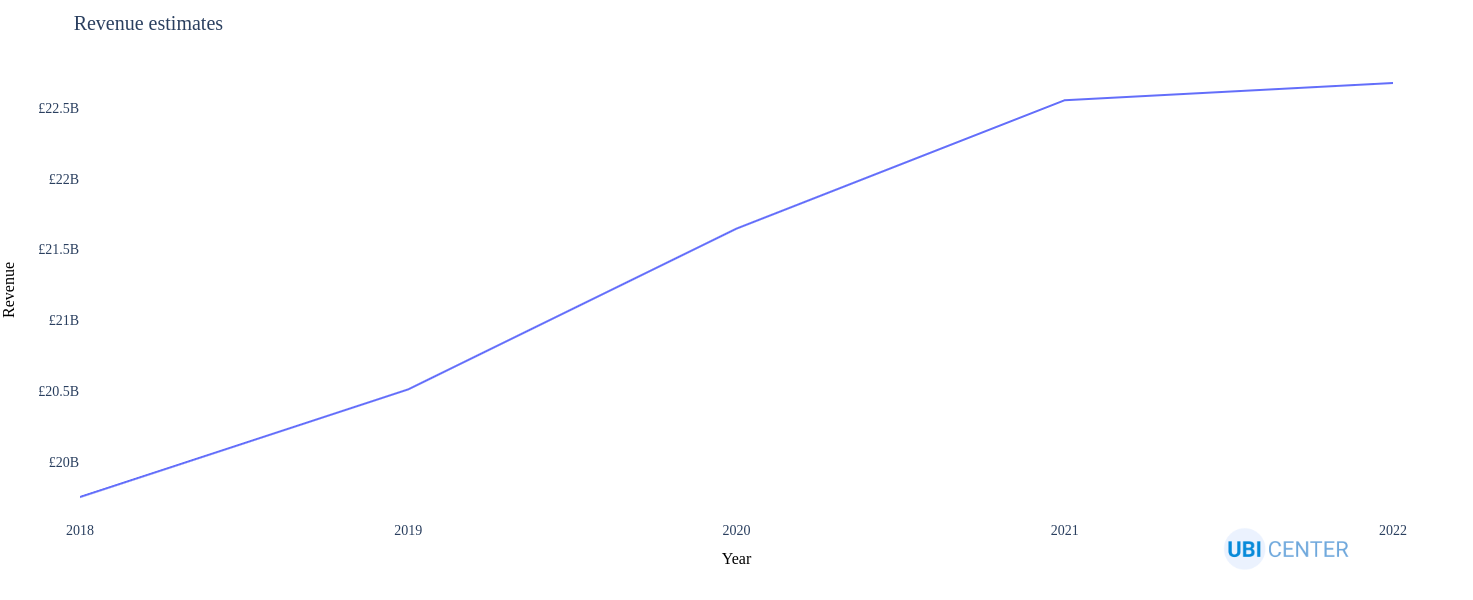

In [59]:
import plotly.express as px
from ubicenter import format_fig
import numpy as np

years = list(range(2018, 2023))
revenue = -np.array([abolish_sim.calc("net_income", period=year).sum() - baseline.calc("net_income", period=year).sum() for year in years])

format_fig(px.line(x=years, y=revenue).update_layout(title="Revenue estimates", xaxis_tickvals=years, xaxis_title="Year", yaxis_title="Revenue", yaxis_tickprefix="£"))

In [67]:
# add UBI

child_allowance_amount = revenue[2] / baseline.calc("is_child").sum()

from openfisca_uk.api import *

class child_allowance(Variable):
    value_type = float
    entity = Person
    definition_period = YEAR
    label = "UBI"
    
    def formula(person, period, parameters):
        return person("is_child", period) * child_allowance_amount
    
class benefits(BASELINE_VARIABLES.benefits):
    def formula(person, period, parameters):
        return BASELINE_VARIABLES.benefits.formula(person, period, parameters) + person("child_allowance", period)

add_UBI = (
    reforms.structural.new_variable(child_allowance),
    reforms.structural.restructure(benefits),
)

full_replacement = (abolish_child_benefits, add_UBI)

CA_sim = Microsimulation(full_replacement)

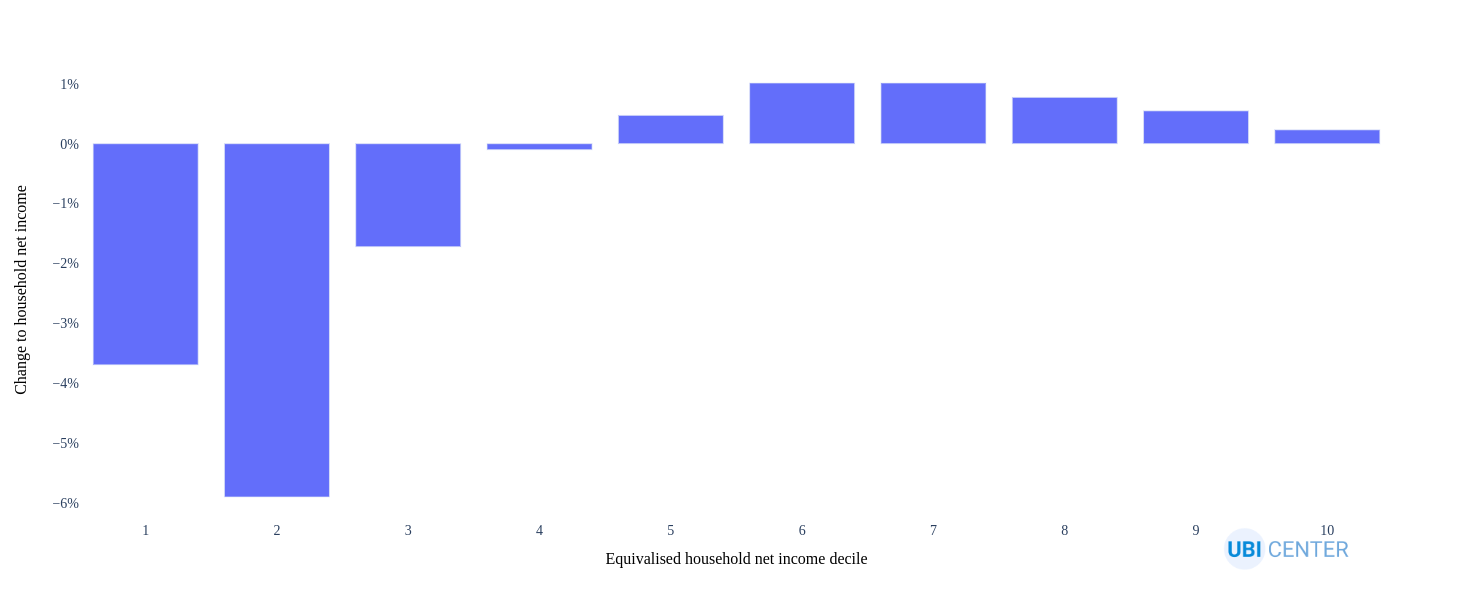

In [78]:
from openfisca_uk import graphs

format_fig(graphs.decile_chart(full_replacement, "equiv_household_net_income", "household_net_income", relative=True))

In [95]:
raise_taxes = (
    reforms.parametric.set_parameter("tax.income_tax.rates.uk[0].rate", 0.25),
    reforms.parametric.set_parameter("tax.income_tax.rates.uk[1].rate", 0.42),
    reforms.parametric.set_parameter("tax.income_tax.rates.uk[2].rate", 0.46),
    reforms.parametric.set_parameter("tax.income_tax.allowances.personal_allowance.amount", 8000)
)

revenue = baseline.calc("net_income").sum() - Microsimulation(abolish_child_benefits, raise_taxes).calc("net_income").sum() 
new_CA_amount = revenue / baseline.calc("is_child").sum()

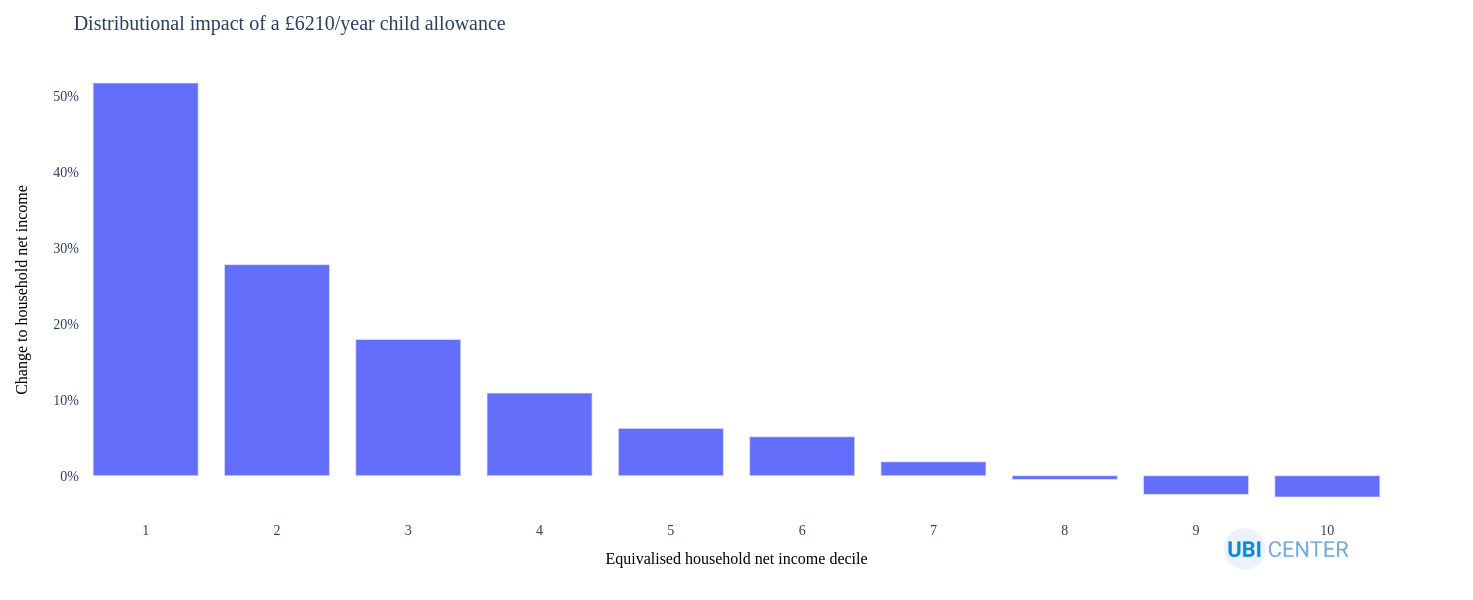

In [101]:
class child_allowance(Variable):
    value_type = float
    entity = Person
    definition_period = YEAR
    label = "UBI"
    
    def formula(person, period, parameters):
        return person("is_child", period) * new_CA_amount
    
class benefits(BASELINE_VARIABLES.benefits):
    def formula(person, period, parameters):
        return BASELINE_VARIABLES.benefits.formula(person, period, parameters) + person("child_allowance", period)

add_UBI = (
    reforms.structural.new_variable(child_allowance),
    reforms.structural.restructure(benefits),
)

full_replacement = (abolish_child_benefits, raise_taxes, add_UBI)

CA_sim = Microsimulation(full_replacement)

CA_amount = int(round(CA_sim.calc("child_allowance").max()))

format_fig(graphs.decile_chart(full_replacement, "equiv_household_net_income", "household_net_income", relative=True).update_layout(title=f"Distributional impact of a £{CA_amount}/year child allowance"))